<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/hw12_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Introduce

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ROOT='gdrive/My Drive/Colab Notebooks/Hongyi_Li/data'
# Download dataset
!gdown --id '12-07DSquGdzN3JBHBChN4nMo3i8BqTiL' --output real_or_drawing.zip
# Unzip the files
!unzip real_or_drawing.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: real_or_drawing/train_data/0/107.bmp  
  inflating: real_or_drawing/train_data/0/108.bmp  
  inflating: real_or_drawing/train_data/0/109.bmp  
  inflating: real_or_drawing/train_data/0/11.bmp  
  inflating: real_or_drawing/train_data/0/110.bmp  
  inflating: real_or_drawing/train_data/0/111.bmp  
  inflating: real_or_drawing/train_data/0/112.bmp  
  inflating: real_or_drawing/train_data/0/113.bmp  
  inflating: real_or_drawing/train_data/0/114.bmp  
  inflating: real_or_drawing/train_data/0/115.bmp  
  inflating: real_or_drawing/train_data/0/116.bmp  
  inflating: real_or_drawing/train_data/0/117.bmp  
  inflating: real_or_drawing/train_data/0/118.bmp  
  inflating: real_or_drawing/train_data/0/119.bmp  
  inflating: real_or_drawing/train_data/0/12.bmp  
  inflating: real_or_drawing/train_data/0/120.bmp  
  inflating: real_or_drawing/train_data/0/121.bmp  
  inflating: real_or_drawing/train_data/0/122.bmp  
  inflating: real_or_drawing/train_data

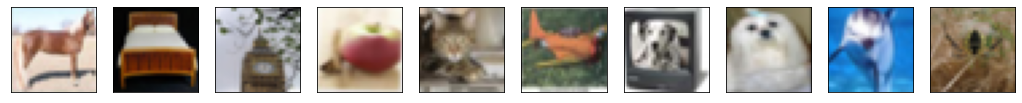

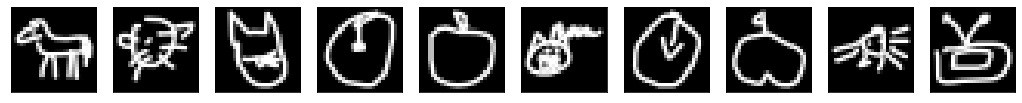

In [0]:
import os
import numpy as np
import torch
from torch import nn,optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def show_img(root):
  titles=['horse','bed','clock','apple','cat','plane','television','dog','dolphin','spider']
  plt.figure(figsize=(18,18))
  imgs=[]
  if root.split('/')[-1].split('_')[0]=='train':
    for i in range(10):
      filename=os.path.join(root,str(i)+'/'+str(500*i)+'.bmp')
      imgs.append(Image.open(filename))
  else:
    for i in range(10):
      filename=os.path.join(root,'0/'+str(i).rjust(5,'0')+'.bmp')
      imgs.append(Image.open(filename))
  for i,img in enumerate(imgs):
    plt.subplot(1,10,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
train_root='./real_or_drawing/train_data'
test_root='./real_or_drawing/test_data'
show_img(train_root)
show_img(test_root)

In [0]:
a=Image.open(os.path.join(test_root,'0/'+str(1).rjust(5,'0')+'.bmp'))
np.array(a).shape

(28, 28, 3)

# Special Domain Knowledge

([], <a list of 0 Text major ticklabel objects>)

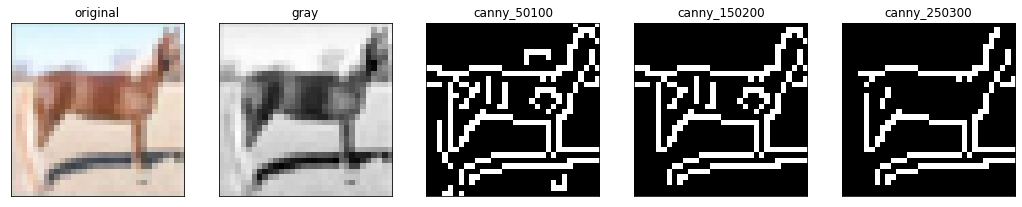

In [0]:
import cv2
plt.figure(figsize=(18,18))
original_img='real_or_drawing/train_data/0/0.bmp'
plt.subplot(1,5,1)
plt.imshow(Image.open(original_img))
plt.title('original')
plt.xticks([])
plt.yticks([])

gray_img=cv2.cvtColor(cv2.imread(original_img),cv2.COLOR_BGR2GRAY)
plt.subplot(1,5,2)
plt.imshow(gray_img,cmap='gray')
plt.title('gray')
plt.xticks([])
plt.yticks([])

canny_50100=cv2.Canny(gray_img,50,100)
plt.subplot(1,5,3)
plt.imshow(canny_50100,cmap='gray')
plt.title('canny_50100')
plt.xticks([])
plt.yticks([])

canny_150200=cv2.Canny(gray_img,150,200)
plt.subplot(1,5,4)
plt.imshow(canny_150200,cmap='gray')
plt.title('canny_150200')
plt.xticks([])
plt.yticks([])

canny_250300=cv2.Canny(gray_img,250,300)
plt.subplot(1,5,5)
plt.imshow(canny_250300,cmap='gray')
plt.title('canny_250300')
plt.xticks([])
plt.yticks([])

# Data Process

In [0]:
import torch.nn.functional as F
from torch.autograd import Function
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_trnsform=transforms.Compose([
  transforms.Grayscale(),
  transforms.Lambda(lambda x:cv2.Canny(np.array(x),170,300)),
  transforms.ToPILImage(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15,fill=(0,)),
  transforms.ToTensor()
])
target_transform=transforms.Compose([
  transforms.Grayscale(),
  transforms.Resize((32,32)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15,fill=(0,)),
  transforms.ToTensor()
])

source_dataset=ImageFolder('real_or_drawing/train_data',transform=source_trnsform)
target_dataset=ImageFolder('real_or_drawing/test_data',transform=target_transform)

source_dataloader=DataLoader(source_dataset,batch_size=32,shuffle=True,num_workers=4)
target_dataloader=DataLoader(target_dataset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader=DataLoader(target_dataset,batch_size=128,shuffle=False,num_workers=4)

In [0]:
for X,Y in source_dataloader:
  print(X.shape,Y.shape)
  break
for X,_ in target_dataloader:
  print(X.shape)
  break

torch.Size([32, 1, 32, 32]) torch.Size([32])
torch.Size([32, 1, 32, 32])


# Model
> Feature extractor:VGG      
> Label Predictor/Domain Classifier:MLP

In [0]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
      nn.Conv2d(1,64,3,1,1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(64,128,3,1,1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(128,256,3,1,1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(256,256,3,1,1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(256,512,3,1,1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2)    # 512*1*1
    )

  def forward(self,x):
    x=self.conv(x).squeeze()
    return x

class LabelPredictor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer=nn.Sequential(
      nn.Linear(512,512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.ReLU(),

      nn.Linear(512,10)
    )

  def forward(self,x):
    c=self.layer(x)
    return c

class DomainClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer=nn.Sequential(
      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,1)
    )

  def forward(self,x):
    x=self.layer(x)
    return x

# Pre-processing

In [0]:
feature_extractor=FeatureExtractor().cuda()
label_predictor=LabelPredictor().cuda()
domain_classifier=DomainClassifier().cuda()

class_criterion=nn.CrossEntropyLoss()
domain_criterion=nn.BCEWithLogitsLoss()

optimizer_F=optim.Adam(feature_extractor.parameters())
optimizer_C=optim.Adam(label_predictor.parameters())
optimizer_D=optim.Adam(domain_classifier.parameters())

# Train

In [0]:
def train_epoch(source_dataloader,target_dataloader,lamb):
  running_D_loss,running_F_loss=0.,0.
  total_hit,total_num=0.,0.

  for i,((source_data,source_label),(target_data,_)) in enumerate(zip(source_dataloader,target_dataloader)):
    source_data=source_data.cuda()
    source_label=source_label.cuda()
    target_data=target_data.cuda()

    mixed_data=torch.cat([source_data,target_data],dim=0)
    domain_label=torch.zeros([source_data.shape[0]+target_data.shape[0],1]).cuda()
    domain_label[:source_data.shape[0]]=1

    # 训练域分类器
    feature=feature_extractor(mixed_data)
    domain_logits=domain_classifier(feature.detach())
    loss=domain_criterion(domain_logits,domain_label)
    running_D_loss+=loss.item()
    optimizer_D.zero_grad()
    loss.backward()
    optimizer_D.step()

    # 训练特征提取器和分类器
    class_logits=label_predictor(feature[:source_data.shape[0]])
    domain_logits=domain_classifier(feature)
    loss=class_criterion(class_logits,source_label)-lamb*domain_criterion(domain_logits,domain_label)
    running_F_loss+=loss.item()
    optimizer_F.zero_grad()
    optimizer_C.zero_grad()
    loss.backward()
    optimizer_F.step()
    optimizer_C.step()

    total_hit+=torch.sum(torch.argmax(class_logits,dim=1)==source_label).item()
    total_num+=source_data.shape[0]
    print(i,end='\r')
  return running_D_loss/(i+1),running_F_loss/(i+1),total_hit/total_num
  
# 训练200 epochs
for epoch in range(200):
  train_D_loss,train_F_loss,train_acc=train_epoch(source_dataloader,target_dataloader,lamb=0.1)
  torch.save(feature_extractor.state_dict(),f'extractor_model.bin')
  torch.save(label_predictor.state_dict(),f'predictor_model.bin')
  print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f},\
     acc: {:6.4f}'.format(epoch,train_D_loss,train_F_loss,train_acc))


epoch   0: train D loss: 0.5426, train F loss: 1.2991,          acc: 0.5244
epoch   1: train D loss: 0.5465, train F loss: 1.2658,          acc: 0.5420
epoch   2: train D loss: 0.5479, train F loss: 1.2032,          acc: 0.5572
epoch   3: train D loss: 0.5394, train F loss: 1.1754,          acc: 0.5762
epoch   4: train D loss: 0.5419, train F loss: 1.1396,          acc: 0.5818
epoch   5: train D loss: 0.5365, train F loss: 1.1001,          acc: 0.5970
epoch   6: train D loss: 0.5232, train F loss: 1.0835,          acc: 0.6038
epoch   7: train D loss: 0.5219, train F loss: 1.0458,          acc: 0.6216
epoch   8: train D loss: 0.5358, train F loss: 0.9982,          acc: 0.6346
epoch   9: train D loss: 0.5294, train F loss: 0.9959,          acc: 0.6360
epoch  10: train D loss: 0.5147, train F loss: 0.9386,          acc: 0.6496
epoch  11: train D loss: 0.5057, train F loss: 0.9255,          acc: 0.6562
epoch  12: train D loss: 0.5187, train F loss: 0.8588,          acc: 0.6832
epoch  13: t

In [0]:
label_predictor.eval()
feature_extractor.eval()
result=[]
for i,(test_data,_) in enumerate(test_dataloader):
  test_data=test_data.cuda()
  class_logits=label_predictor(feature_extractor(test_data))
  x=torch.argmax(class_logits,dim=1).cpu().detach().numpy()
  result.append(x)

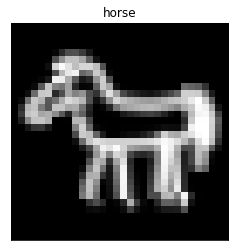

In [0]:
titles=['horse','bed','clock','apple','cat','plane','television','dog','dolphin','spider']
for test_da,_ in test_dataloader:
  test_data=test_da.cpu().detach().numpy()
  plt.imshow(test_data[0].squeeze(),cmap='gray')
  plt.title(titles[result[0][0]])
  plt.xticks([])
  plt.yticks([])
  break